In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

%matplotlib inline


In [2]:
# x = [0.0]

# for t in range(100):
#     x.append(np.sin((t+1)*0.2))
#     x.append(0.5*x[-1] + 25*x[-1]/(1 + x[-1]**2) + 8*np.cos(1.2*t))
    
# toy_sequence=np.array(x);
# plt.plot(toy_sequence);

In [3]:
toy_sequence = np.array([1,2,6,3,10,5,6], dtype=float)

data_simple = torch.FloatTensor(np.stack((toy_sequence[:-1], toy_sequence[1:])).T)
# data_simple

In [4]:
import pickle

H = 20

h1 = nn.Sequential(nn.Linear(1, H), nn.ReLU(), 
#                    nn.Linear(H, H), nn.ReLU(), 
                   nn.Linear(H, H), nn.ReLU(), 
                   nn.Linear(H, 1))
h2 = pickle.loads(pickle.dumps(h1))

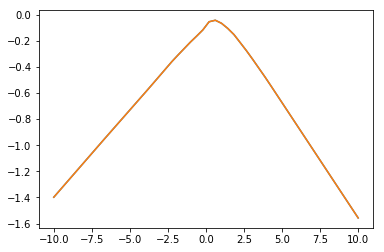

In [5]:
domain = np.linspace(-10, 10)

out = h1(torch.FloatTensor(domain)[:,None]).detach().numpy()
plt.plot(domain, out)
out = h2(torch.FloatTensor(domain)[:,None]).detach().numpy()
plt.plot(domain, out)

## Training to first-order objective

In [6]:
opt1 = torch.optim.Adagrad(h1.parameters(), lr=0.1)

In [7]:
# data_simple[:,0][:,None] + h1(data_simple[:,0][:,None]), 


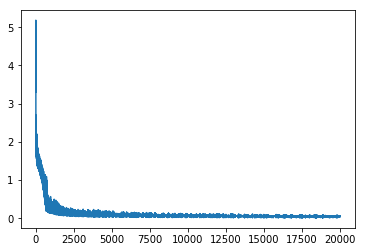

In [8]:
train_loss = []
for i in range(20000):
    opt1.zero_grad()
    estimate = data_simple[:,0][:,None] + h1(data_simple[:,0][:,None])
    loss = (estimate - data_simple[:,1][:,None]).abs().mean()
    loss.backward()
    train_loss.append(loss.item())
    opt1.step()
    
plt.plot(train_loss)

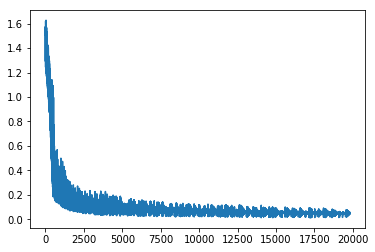

In [9]:
plt.plot(train_loss[200:])

## second-order

In [10]:

opt2 = torch.optim.Adagrad(h2.parameters(), lr=0.1)

In [11]:
data = torch.FloatTensor(np.stack((toy_sequence[:-2], toy_sequence[1:-1], toy_sequence[2:])).T)

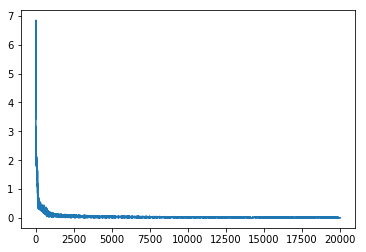

In [12]:
train_loss2 = []

for i in range(20000):
    opt2.zero_grad()
    estimate = data[:,1][:,None] + 0.5*(3*h2(data[:,1][:,None]) - h2(data[:,0][:,None]))
    loss = (estimate - data[:,2][:,None]).abs().mean()
    loss.backward()
    train_loss2.append(loss.item())
    opt2.step()
    
plt.plot(train_loss2);

## Look at the learned functions

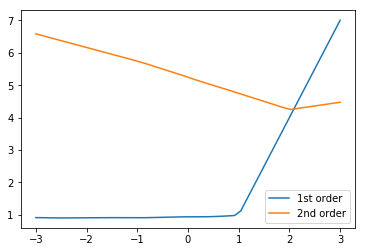

In [13]:
domain = np.linspace(-3, 3)

out = h1(torch.FloatTensor(domain)[:,None]).detach().numpy()
plt.plot(domain, out)
out = h2(torch.FloatTensor(domain)[:,None]).detach().numpy()
plt.plot(domain, out)
plt.legend(['1st order', '2nd order']);

## Test use of each in "simple" integrator

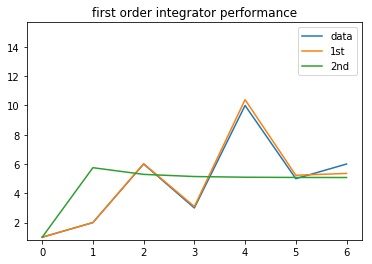

In [14]:
def simple_integrator(init, h, num_steps):
    z = [init]
    for t in range(num_steps):
        z.append((z[-1] + h(torch.FloatTensor([[z[-1]]]))).item())
    return np.array(z)


train1test1 = simple_integrator(toy_sequence[0], h1, len(toy_sequence)-1)
train2test1 = simple_integrator(toy_sequence[0], h2, len(toy_sequence)-1)

plt.plot(toy_sequence)
ylim = np.array(plt.ylim())*1.5
plt.plot(train1test1)
plt.plot(train2test1)
plt.ylim(ylim)
# plt.xlim(700, 1000)
plt.legend(['data', '1st', '2nd']);
plt.title('first order integrator performance');

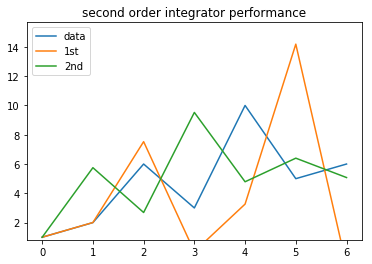

In [15]:
def second_order_integrator(init, h, num_steps):
    z = simple_integrator(init, h, 1).tolist()
    for t in range(num_steps-1):
        z.append((z[-1] + 0.5*(3*h(torch.FloatTensor([[z[-1]]])) - h(torch.FloatTensor([[z[-2]]])))).item())
    return np.array(z)

train1test2 = second_order_integrator(toy_sequence[0], h1, len(toy_sequence)-1)
train2test2 = second_order_integrator(toy_sequence[0], h2, len(toy_sequence)-1)

plt.plot(toy_sequence)
ylim = np.array(plt.ylim())*1.5
plt.plot(train1test2)
plt.plot(train2test2)
plt.ylim(ylim);
# plt.xlim(700, 1000)
plt.legend(['data', '1st', '2nd']);
plt.title('second order integrator performance');